In [1]:
# git clone https://github.com/NVlabs/stylegan2.git

fatal: destination path 'stylegan2' already exists and is not an empty directory.


In [2]:

%tensorflow_version 1.x
import tensorflow as tf

# Make sure you use tensoflow version 1
print('Tensorflow version: {}'.format(tf.__version__) )

# Use '%' prefix in colab or run this in command line
%cd /content/stylegan2

import pretrained_networks
from google_drive_downloader import GoogleDriveDownloader as gdd

# Links to the pre-trained anime StyleGAN weights, you can copy the file to your own drive, if it's over the download limit
url = 'https://drive.google.com/open?id=1WNQELgHnaqMTq3TlrnDaVkyrAH8Zrjez'
model_id = url.replace('https://drive.google.com/open?id=', '')

network_pkl = '/content/models/model_%s.pkl' % model_id#(hashlib.md5(model_id.encode()).hexdigest())
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path=network_pkl)

# It returns 3 networks, we will be mainly using Gs
# _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
# _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
# Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

TensorFlow 1.x selected.
Tensorflow version: 1.15.2
/content/stylegan2
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [3]:
import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

In [4]:

import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

# Get tf noise variables, for the stochastic variation
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

# Trunctation psi value needed for the truncation trick
def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
        
    # Return array of PIL.Image
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

In [5]:
# generate 9 random seeds
seeds = np.random.randint(10000000, size=9)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, 0.5)

[3512911 3853147 5731208 5949604 7266478 6592429 4240379 8146769  764394]


9it [00:03,  2.48it/s]


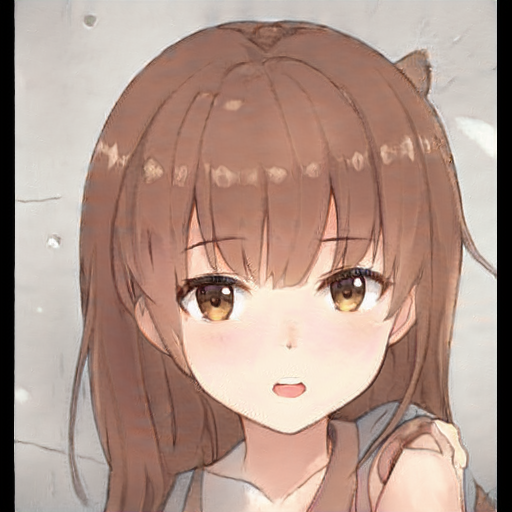

In [17]:
imgs[0]

In [7]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas


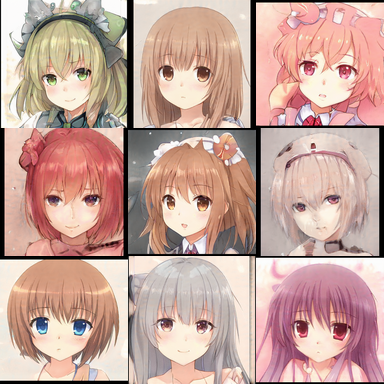

In [8]:
createImageGrid(imgs, rows=3)

In [9]:
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

7it [00:00, 16.14it/s]


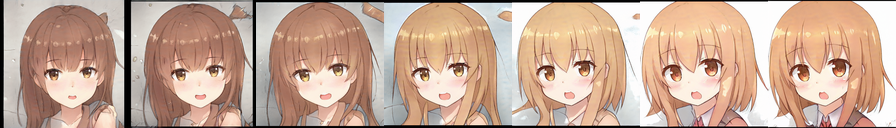

In [10]:
seeds = np.random.randint(10000000,size=2)
zs=generate_zs_from_seeds(seeds)
imgs=generate_images(interpolate(zs,7),0.5)
createImageGrid(imgs, rows=1)

In [13]:

import scipy
import moviepy.editor

grid_size = [3,3]
duration_sec = 5
smoothing_sec = 1.0
image_zoom = 1
fps = 15
random_seed = np.random.randint(0, 999)

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * len(Gs.input_shape), mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))


def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=0.7,
                          randomize_noise=False, output_transform=fmt, 
                          minibatch_size=16)

    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

# Generate video.
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
video_clip.write_videofile('random_grid_%s.mp4' % random_seed, fps=fps, codec='libx264', bitrate='2M')

#video_clip.write_gif('random_grid_%s.gif' % random_seed, fps=fps)

[MoviePy] >>>> Building video random_grid_12.mp4
[MoviePy] Writing video random_grid_12.mp4


 99%|█████████▊| 75/76 [00:18<00:00,  4.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: random_grid_12.mp4 



In [14]:
random_grid_12.mp4

NameError: ignored